In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
plt.rcParams.update({'font.size': 15})

# Setting Up The FPGA

Before running any code, make sure you specify your board in the sifpga_crs_corr_capture.py. The call to CRS_CORR_CAPTURE at the end of the file should look like:
```
   1061 ccc = CRS_CORR_CAPTURE(hwm = 'crs 0032',
   1062                        stderr_log_level = 'debug',
   1063                        prog = 2,
   1064                        mode = 'corr8',
   1065                        make_directories = False,
   1066                        data_path = '/home/ih/d3a/rfsoc_data')
```   
 where you replace hwm = 'crs 0032' with your CRS board's serial number. If you are running this locally and not at DRAO, make sure to set the make_directories flag to false.

Run the line below with whatever path is correct for your local install for pychfpga. Point to the file called sifpga_crs_corr_capture.py

Some warnings are normal.

In [3]:
run /home/lmberkhout/src/pychfpga/pychfpga/sifpga_crs_corr_capture.py --verbose=False

Enabling nested event loop on current loop ID 133693230354192
Adding new log handlers of <Logger pychfpga (WARNING)> with level debug
Opened TCPipe socket at ('10.10.10.33', 53962)


There are no IceCrates in the hardware map!


+--------------+-----------------+
| Standalone   | Virt. slot None |
| Motherboards | CRS_SN0032      |
|              | 10.10.10.106    |
+--------------+-----------------+
| Mezz1        | -               |
| Mezz2        | -               |
+--------------+-----------------+

Forcing output 0 mode to LVPECL because fout is high
Forcing output 8 mode to LVPECL because fout is high
Forcing output 9 mode to LVPECL because fout is high
Forcing output 10 mode to LVPECL because fout is high
Forcing output 11 mode to LVPECL because fout is high
Forcing output 12 mode to LVPECL because fout is high
TCPipe: Programming FPGA with 34437356 bytes


chFPGA(None, 'CRS_SN0032'): Sync is not yet implemented on the CRS
chFPGA(None, 'CRS_SN0032'): Sync is not yet implemented on the CRS
chFPGA(None, 'CRS_SN0032'): There is no 1st CROSSBAR module in this firmware build (so there can't be data streamed to the correlators or GPU links!)
chFPGA(None, 'CRS_SN0032'): There is no 2nd CROSSBAR module in this firmware build
chFPGA(None, 'CRS_SN0032'): There is no 3rd CROSSBAR module in this firmware build
{self!r}: Cannot set data width on UltraCT. Command is ignored. 
{self!r}: set_frames_per_packet is not implemented on UltraCT. Packet size is set through the playlist. Command is ignored. 
The platform does not support SYNC sources
chFPGA(None, 'CRS_SN0032'): Sync is not yet implemented on the CRS
chFPGA(None, 'CRS_SN0032'): Sync is not yet implemented on the CRS
FPGAArray(1_boards,0_crates): SYNC will not be checked as not all firmware have SYNC logic
chFPGA(None, 'CRS_SN0032'): Sync is not yet implemented on the CRS


-------------- CHAN[0].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FFF
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[1].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FFF
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[2].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FFF
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[3].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FFF
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[4].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FFF
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None


Calculate the number of seconds per sample to use later and label the board inputs. The board inputs are labelled for user convinience, you can relabel them to whatever is useful for you.

In [4]:
s_per_frame = 2**14*(1/(ccc.fs*1e6)) # samples/frame * seconds/sample. Make sure sampling frequency is in Hz
board_inputs = ['W6Y', 'W6X', 'E6Y', 'E6X', 'M6Y', 'M6X', 'Antenna1', 'Antenna 2'] 

Loop through each polarization and configure the FFT shift schedule. The shift defaulted here does 11 shifts at the first 11 stages of the FFT. 

In [5]:
for n in range(ccc.NPOLS):
    # Configure each FFT
    fft = ccc.i.chan[n].FFT
    fft.FFT_SHIFT = 0b00011111111111 #shift first 11 stages

Set the number of integrations and the number of captures (number of frames integrated on the FPGA). Print out the integration period in second. 

In [6]:
n_fft_integrations = 100 # 
n_fft_captures = 10
fft_integration_period = 2*n_fft_captures*s_per_frame # we capture two contiguous frames at a time, so we recover twice as many frames as captures
print(fft_integration_period)

0.0001024


Capture the number of frames and integration time specified in the previous cell.

In [7]:
%%capture

psd_fft = np.zeros((n_fft_integrations, ccc.NPOLS, len(ccc.f)))
kert_fft = np.zeros((n_fft_integrations, ccc.NPOLS, len(ccc.f)))
fft_cap_adc_ovflws = np.zeros((n_fft_integrations, ccc.NPOLS))
# fft_cap_adc_rms_power_dBm = np.zeros((n_adc_integrations, ccc.NPOLS))
fft_cap_fft_ovflws = np.zeros((n_fft_integrations, ccc.NPOLS))

for n in range(n_fft_integrations):
    print(f'{n}/{n_fft_integrations}')
    
    # Pulse the overflows resets
    for m in range(ccc.NPOLS):

        # Reset ADC stats capture (which is actually in the Scaler module)
        ccc.i.chan[m].SCALER.STATS_FRAME_COUNT = n_fft_captures
        ccc.i.chan[m].SCALER.STATS_CAPTURE = 0 # capture new stats
        # print(m, ccc.i.chan[m].SCALER.STATS_CAPTURE)
        ccc.i.chan[m].SCALER.STATS_CAPTURE = 1
        # print(m, ccc.i.chan[m].SCALER.STATS_CAPTURE)

        # Reset FFT overflow counter
        ccc.i.chan[m].FFT.OVERFLOW_RESET = 1 
        ccc.i.chan[m].FFT.OVERFLOW_RESET = 0

    # Capture data
    d_fft = ccc.read_fft_frames(ncap = n_fft_captures, verbose=0)
    psd_fft[n] = np.mean(np.abs(d_fft)**2, axis = 1)
    kert_fft[n] = np.mean(np.abs(d_fft)**4, axis = 1)

    # Measure ADC overflows
    for m in range(ccc.NPOLS):
        # print(m, ccc.i.chan[m].SCALER.STATS_CAPTURE)
        # print(ccc.i.chan[m].SCALER.STATS_READY)
        ctr = 0
        while True:
            if ccc.i.chan[m].SCALER.STATS_READY == 1:
                fft_cap_adc_ovflws[n, m] = ccc.i.chan[m].SCALER.STATS_ADC_OVERFLOWS
                break
            else:
                ctr += 1
                
    # Measure FFT overflows
    fft_cap_fft_ovflws[n] = [ccc.i.chan[m].FFT.OVERFLOW_COUNT for m in range(ccc.NPOLS)]

Plot the autospectra

/tmp/ipykernel_1574626/1666417478.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 2, n + 1)


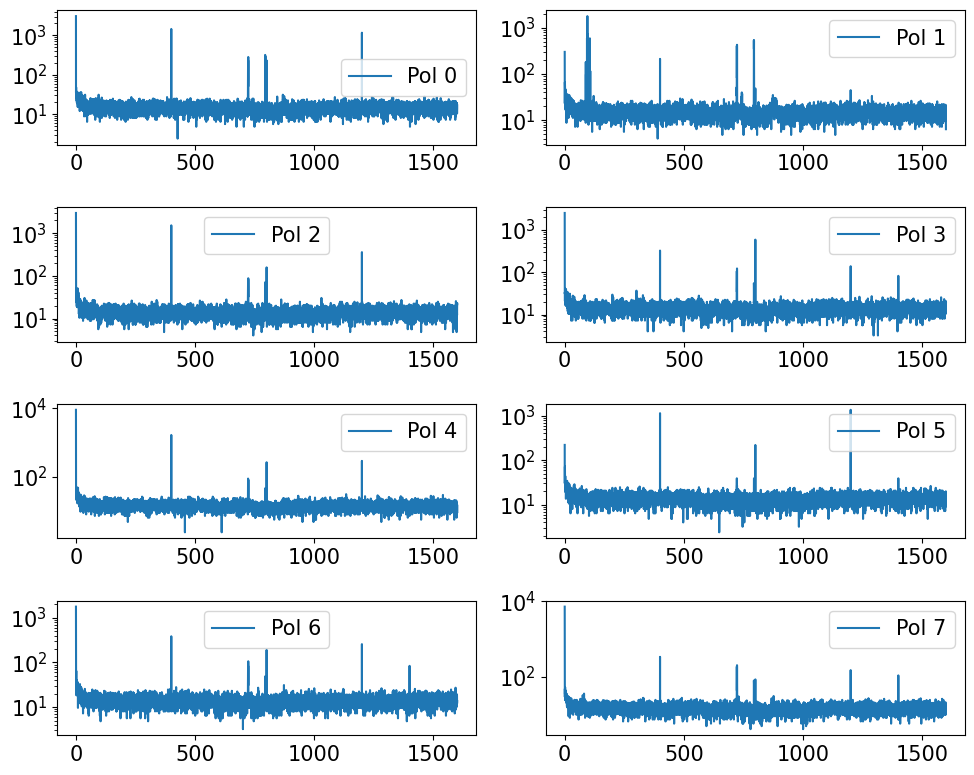

In [8]:
plt.figure(figsize = (10, 8))
plt.title('Integrated PSDs from Firmware FFTs')
for n in range(8):
    plt.subplot(4, 2, n + 1)
    plt.semilogy(ccc.f, psd_fft[0, n], label = f'Pol {n}')
    plt.legend()
plt.tight_layout()

Plot waterfalls

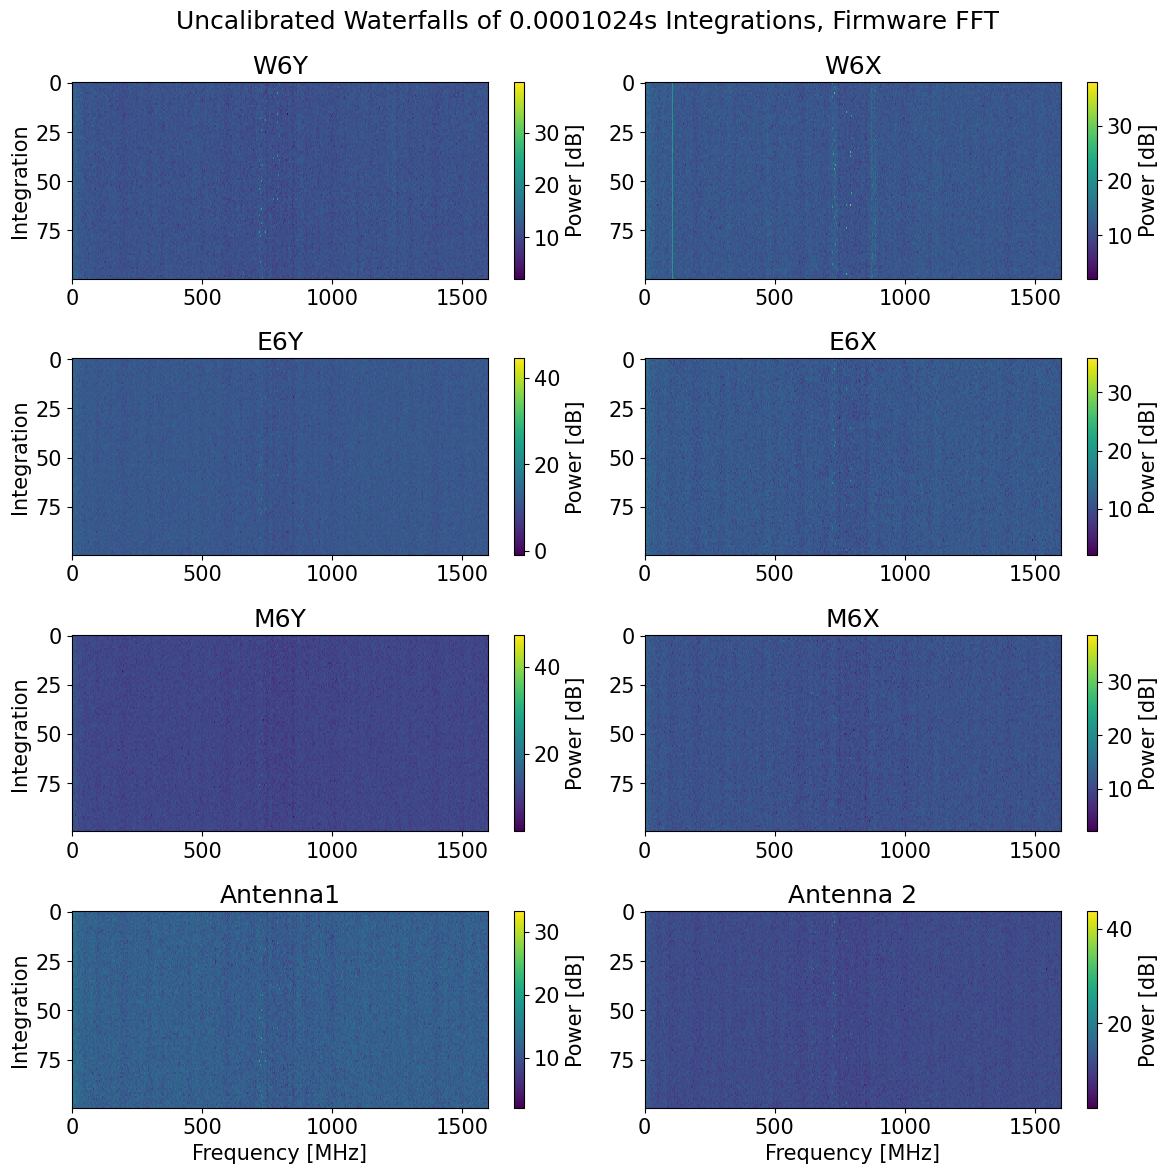

In [9]:
plt.figure(figsize = (12, 12))
plt.suptitle(f'Uncalibrated Waterfalls of {fft_integration_period}s Integrations, Firmware FFT')

for n in range(ccc.NPOLS):
    plt.subplot(4, 2, n + 1)
    plt.title(f'{board_inputs[n]}')
    plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, n, :]))
    plt.colorbar(label = 'Power [dB]')
    if n == 0 or n == 2 or n == 4 or n == 6:
        plt.ylabel('Integration')
    if n == 6 or n== 7:
        plt.xlabel('Frequency [MHz]')
    plt.gca().invert_yaxis()
    plt.tight_layout()

# Using the Pocket Correlator

If you're just using the pocket correlator rather than running the autos, make sure to still set the FFT shift schedule and integration times.

In [11]:
fft_data, fft_rms, gain, lin, log, scaler_data = ccc.compute_gains(gain_type = 'raw',
                                                                   number_of_fft_averages = 250, # 250 is plenty! Recall that it's really 2*250 frames per input in mode 0
                                                                   rms_accuracy_tol = None, # Ignore
                                                                   save_gains = False
                                                                   )

Flushed 205183 packets while emptying UDP buffers
Skipped 65 packets while waiting for a fresh timestamp
mode=0, 8 channel(s), 2 frames per channel, 125 captures
Chan 0: -7000.0 missing packets
Chan 1: -7000.0 missing packets
Chan 2: -7000.0 missing packets
Chan 3: -7000.0 missing packets
Chan 4: -7000.0 missing packets
Chan 5: -7000.0 missing packets
Chan 6: -7000.0 missing packets
Chan 7: -7000.0 missing packets
Timestamp differences: {3906}
(array([], dtype=int64), array([], dtype=int64))
log2 gain [[24.48316614 27.39128123 27.4510448  ... 28.23518668 28.21763478
  28.1545804 ]
 [25.49449076 27.29730634 27.29924544 ... 28.12044576 28.12044576
  28.13576157]
 [24.73042749 27.3760025  27.4619105  ... 28.09367103 28.18707903
  28.07921468]
 ...
 [25.6479575  27.51098356 27.47541697 ... 28.18707903 28.16417718
  28.17064671]
 [25.515801   27.45224405 27.37277016 ... 28.09659739 28.17390336
  28.12348302]
 [22.97648774 27.36955225 27.35472227 ... 28.13886415 28.06504237
  28.13267228]]
l

In [12]:
# Generate product array
prod_idx = np.triu_indices(8)
prod = np.zeros((len(prod_idx[0]), 2))
for n in range(prod.shape[0]):
    prod[n] = (prod_idx[0][n], prod_idx[1][n])
prod = prod.astype(np.int16)

# Configure correlator
ccc.ucap.OUTPUT_SOURCE_SEL = 1 # 0: channelizer data, 1: correlator data
ccc.corr = ccc.i.CORR # correlator object
ccc.corr_receiver = ccc.i.get_corr_receiver() # correlator receiver object
ccc.corr.AUTOCORR_ONLY = 0 # 0: all products, 1: autocorrelation only
ccc.corr.NO_ACCUM = 0 # 0: do accumulate, 1: don't accumulate
ccc.NCORR_PROD = int(ccc.NPOLS*(ccc.NPOLS + 1) // 2)
ccc.corr.INTEGRATION_PERIOD = 16384 - 1 # Min: 8192 - 1 (I think), default: 16384 - 1, max: 65536 - 1. Default typically sufficient to ensure no overflows.
ccc.corr_is_configured = True # Set the correlator configure check

# Set the desired integration time and number of software frames to integrate.
s_per_frame = 2**14*(1/(ccc.fs*1e6)) # samples/frame * seconds/sample. Make sure sampling frequency is in Hz.
set_integration_time = .1 # s
n_firmware_frames = ccc.corr.INTEGRATION_PERIOD + 1 # The number frames to integrate in the FPGA before sending to python
n_software_frames = int(set_integration_time / s_per_frame / n_firmware_frames) # The number of frames to integrate in python
actual_integration_time = n_firmware_frames * n_software_frames * s_per_frame # The true integration time
print(f'Target integration time: {set_integration_time} s')
print(f'Actual integration time: {actual_integration_time} s')

n_integrations = 5

t, vis, counts, sat = ccc.read_corr_frames(data_source = 'adc', # Could be the ADC or the firmware function generator
                                            soft_integ_period = n_software_frames, # Specify the number of software frames
                                            number_of_results = n_integrations, # The number of integrations to return
                                            filename = None, # Ignore
                                            flush = True, # Flushes the UDP buffer. Should be true whenever you're capturing quick bursts.
                                            align = False,
                                            data_timeout = 0.1,
                                            flush_timeout = 0.01,
                                            return_format = 'raw',
                                            verbose = 0, # 0 is most noisy, set to 1 for fewer printours.
                                            corr_is_configured = ccc.corr_is_configured)

Target integration time: 0.1 s
Actual integration time: 0.08388608 s
acc_re shape (N_results, Ncorr, Ncmac, Nprod) = (5, 8192, 36)
Flushing UDP buffer
Flushed 6833 packets
Accumulating software frame #0.0, starting with correlator frame number 46727168 
Received 40940 packets, 0 timeouts, 0 bad packets
Got 100.0% of the packets
Took 0.5802731513977051s to capture corr data


In [13]:
prod_idx = np.triu_indices(8)
prod = np.zeros((len(prod_idx[0]), 2))
for n in range(prod.shape[0]):
    prod[n] = (prod_idx[0][n], prod_idx[1][n])
prod = prod.astype(np.int16)

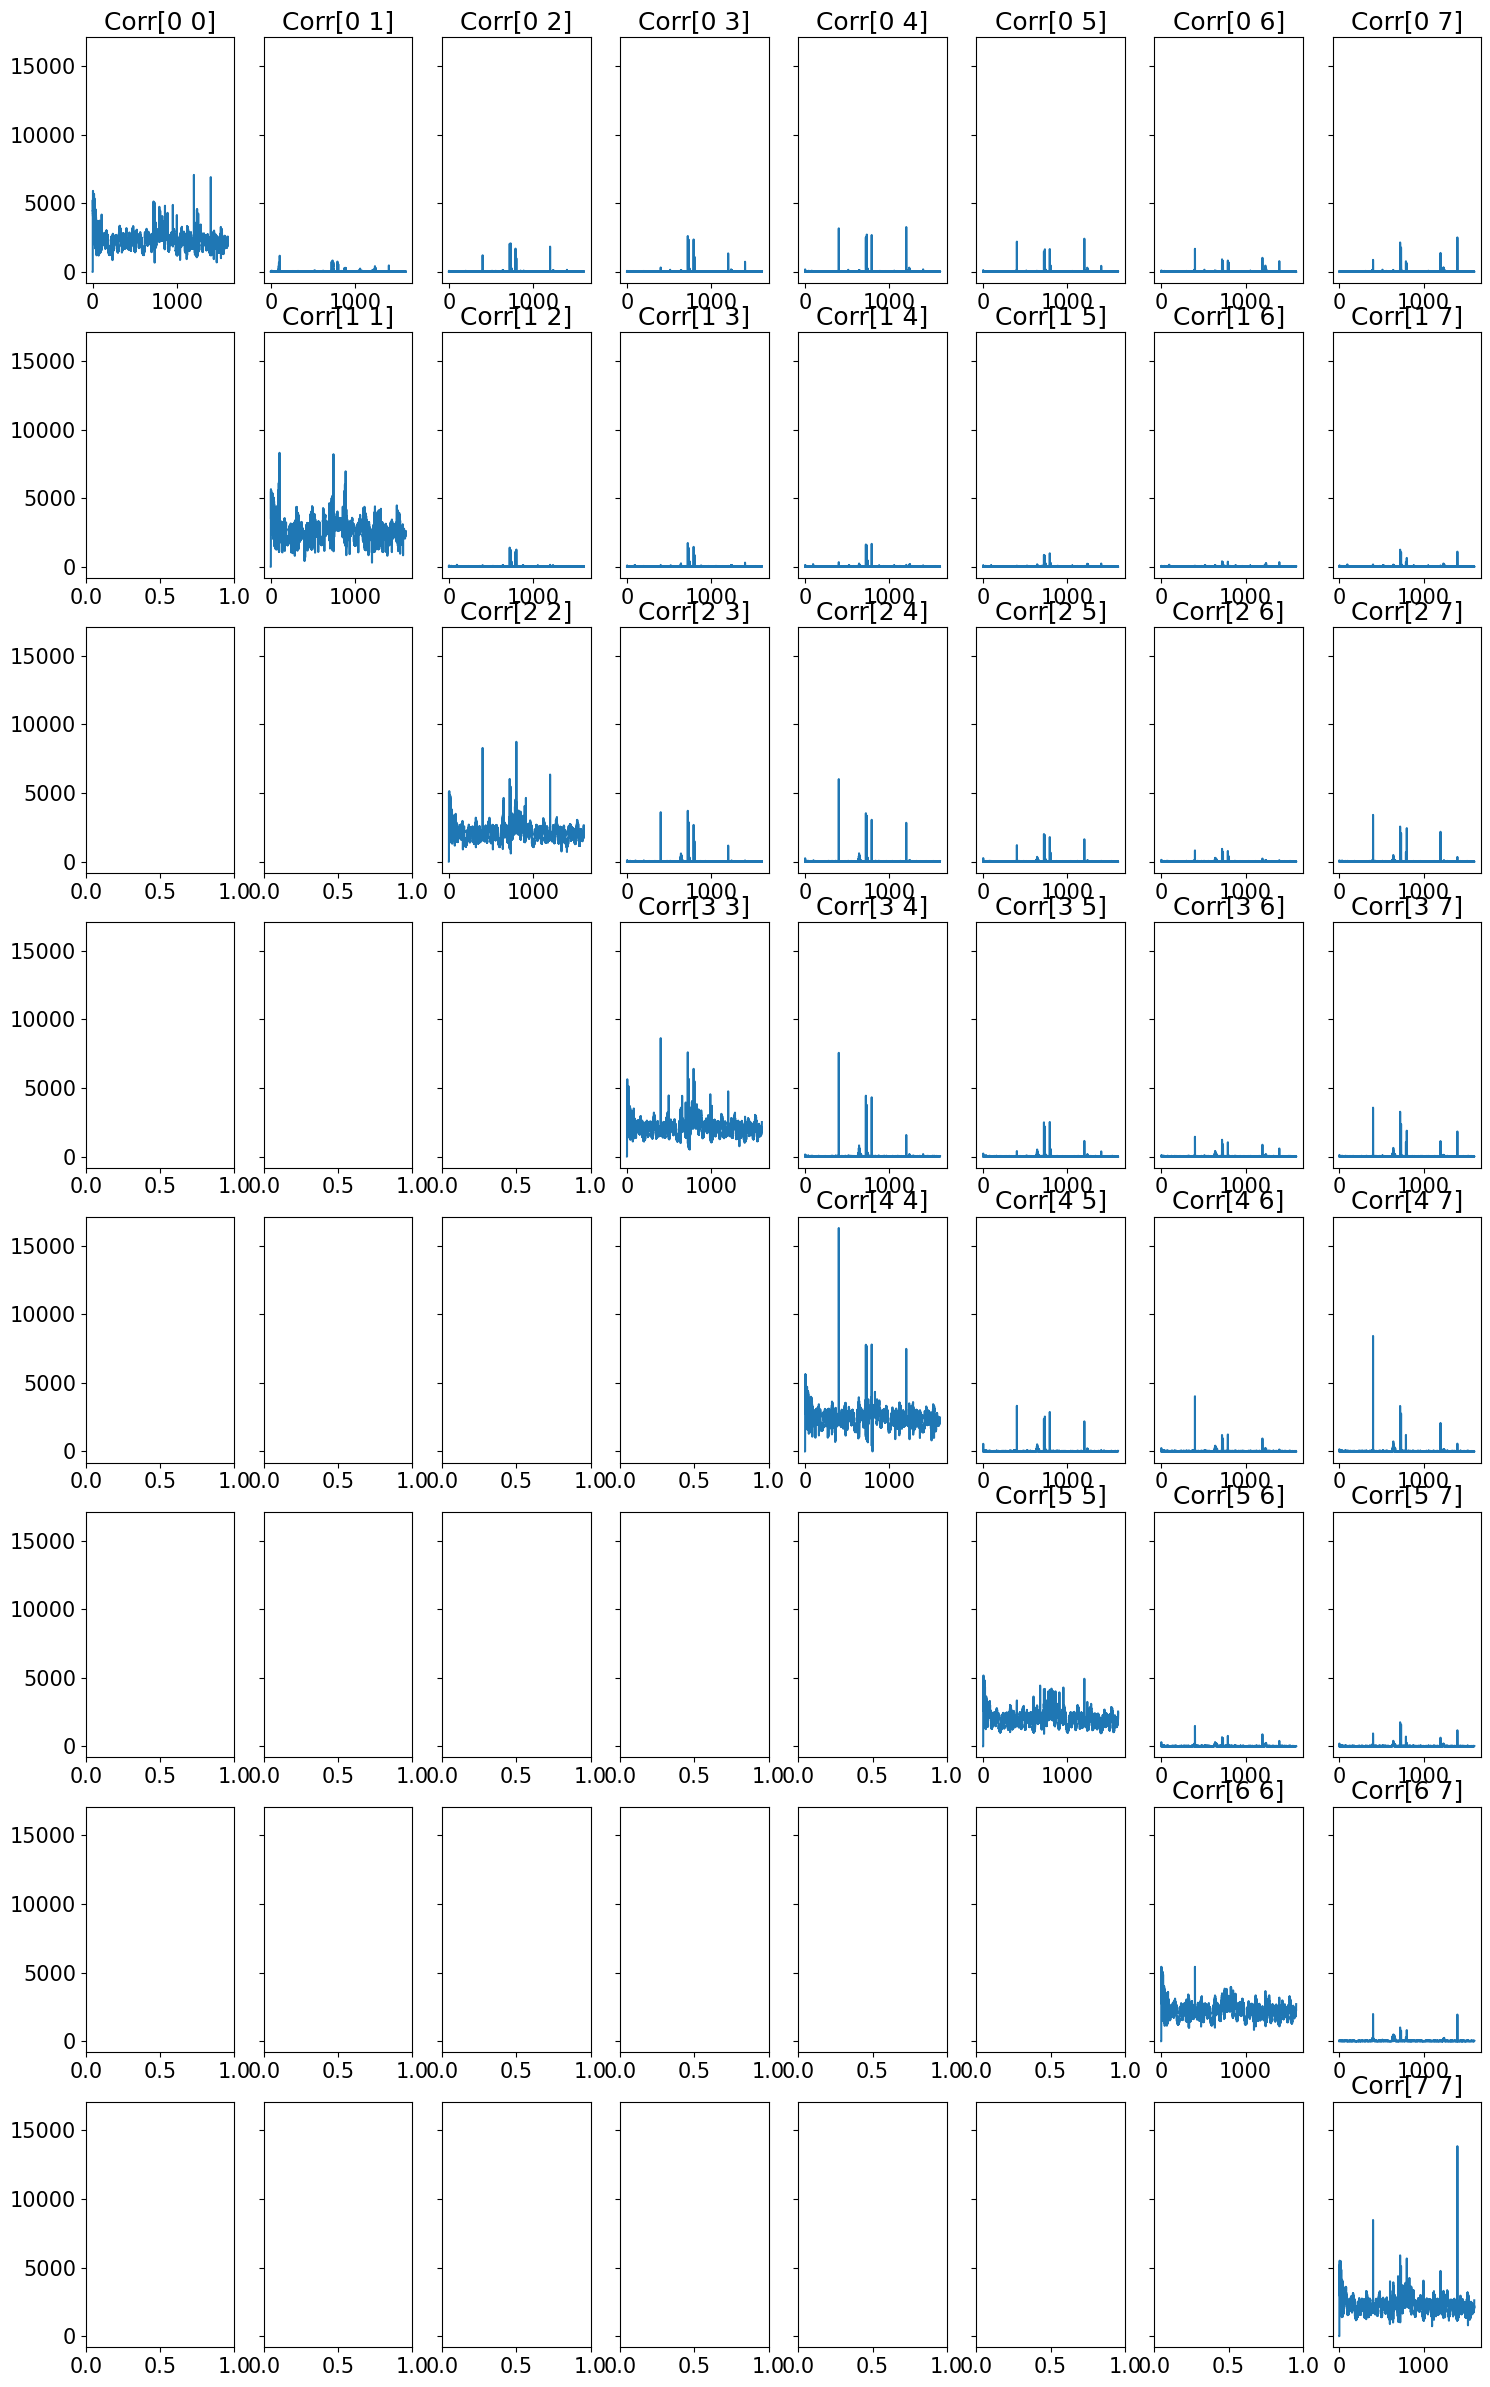

In [14]:
fig, axs = plt.subplots(8,8,figsize=(18,30),sharey=True)
for i in range(36):
    axs[prod[i][0],prod[i][1]].plot(ccc.f,np.abs(vis[0,:,i]))
    axs[prod[i][0],prod[i][1]].set_title("Corr{antcorr}".format(antcorr = prod[i]))